In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_style("darkgrid")
sns.set_theme("paper")

In [ ]:
normal_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_edge_data.csv")
rerun_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_edge_data.csv")
private_edge_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_edge_data.csv")
private_edge_data = private_edge_data[private_edge_data["failed"] != True]
# remove the bad pfkfb3 edges and add the reruns using the fixed version of kartograf
normal_edge_data = normal_edge_data[(normal_edge_data["system name"] != "pfkfb3") & (normal_edge_data["failed"] != True)]
normal_edge_data = pd.concat([normal_edge_data, rerun_edge_data], ignore_index=True)
normal_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,28.411707,0.110235,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,32.545681,0.207117,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,29.240601,0.198225,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,4.466974,0.022621,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.812082,0.138050,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,68.239609,0.098195,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3
1192,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,67.026726,0.157674,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3
1193,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,54.050873,0.165275,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3
1194,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,52.765472,0.133457,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3


In [74]:
private_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_dDG (kcal/mol),complex_repeat_1_com_drift_max,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed
0,unknown_ligand_6,unknown_ligand_9,1.000000,0,1.0,1.000000,1.000000,0.999901,21,0,...,2.231493e-10,1.496107,2.483988,0.090909,0.000000,2.839362e-10,1.771044,2.238705,0.090909,NaN
1,unknown_ligand_3,unknown_ligand_15,0.904837,0,1.0,0.046432,1.000000,0.761981,20,1,...,2.455996e-02,1.615484,2.155722,0.103056,-0.601893,2.564494e-02,1.976220,3.056871,0.103643,NaN
2,unknown_ligand_15,unknown_ligand_21,0.904837,0,1.0,0.046591,1.000000,0.762179,20,0,...,3.643987e-02,2.341021,3.475891,0.110198,1.370174,3.546106e-02,2.180326,3.084103,0.106760,NaN
3,unknown_ligand_15,unknown_ligand_5,0.904837,0,1.0,0.047457,1.000000,0.757272,20,0,...,2.883455e-02,1.911599,2.986635,0.119243,-0.866684,3.144320e-02,1.628999,2.337637,0.117861,NaN
4,unknown_ligand_21,unknown_ligand_5,0.818731,0,1.0,0.091968,1.000000,0.677922,20,1,...,4.467752e-02,1.444678,3.283127,0.121850,-1.953068,5.534813e-02,1.782087,3.081785,0.126268,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1427,ligand11,ligand12,0.020242,0,1.0,0.205950,0.405952,0.895260,26,16,...,4.390646e-01,125.984756,126.013779,0.008125,-152.669851,6.001595e-01,111.879089,111.980225,0.002787,NaN
1428,ligand0,ligand11,0.030197,0,1.0,0.193953,0.406137,0.942570,26,9,...,4.335208e-01,118.773781,118.922112,0.012684,114.461670,2.665547e-01,120.105179,120.169167,0.012729,NaN
1429,ligand8,ligand3,0.212248,0,1.0,0.165417,0.645056,0.793032,28,7,...,3.166176e-01,122.461555,122.546555,0.017953,-21.543263,2.768983e-01,115.884491,115.910095,0.016368,NaN
1430,ligand2,ligand3,0.272532,0,1.0,0.157825,0.671910,0.831267,28,5,...,2.358288e-01,121.872475,122.149765,0.028739,100.395024,1.945049e-01,122.015831,122.021210,0.025002,NaN


In [81]:
# load the public and private DG
public_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv")
rerun_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_calculated_dg_data.csv")
private_dg_data = pd.read_csv("https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_calculated_dg_data.csv")
public_dg_data = public_dg_data[(public_dg_data["system name"] != "pfkfb3") ]
public_dg_data = pd.concat([public_dg_data, rerun_dg_data], ignore_index=True)

In [82]:
private_dg_data

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name
0,unknown_ligand_3,-11.138621,0.112866,-11.295068,0.009218,ASAP,Enterovirus
1,unknown_ligand_15,-10.195037,0.097533,-10.146950,0.054278,ASAP,Enterovirus
2,unknown_ligand_7,-10.798933,0.098011,-10.678739,0.026163,ASAP,Enterovirus
3,unknown_ligand_21,-9.901235,0.152421,-9.819696,0.054102,ASAP,Enterovirus
4,unknown_ligand_19,-10.717638,0.365485,-9.915145,0.139450,ASAP,Enterovirus
...,...,...,...,...,...,...,...
859,ligand6,-9.455397,0.614779,-8.236271,0.000000,Roche,target_D
860,ligand3,-5.385738,0.715944,-5.933406,0.000000,Roche,target_D
861,ligand8,-6.682645,1.244110,-6.782175,0.000000,Roche,target_D
862,ligand5,-7.112522,1.238355,-5.933406,0.000000,Roche,target_D


In [175]:
# create a second filtered version of the private dataset to correct for duplicate ligands and ligands reported at the assay limits
issue_ligands = {
    ("GSK", "GSK_PRIVATE_1"): {"tautomer": ["ligand23", "ligand18"], "enantiomer":["ligand9"]},
    ("Janssen", "systemD_set1"): {"tautomer": ["ligand36", "ligand1"], "enantiomer": ["ligand54"], "assay_high": ["ligand44", "ligand23", "ligand45", "ligand25", "ligand18", "ligand19", "ligand32"]},
    ("Merck", "merck_private_T"): {"enantiomer": ["ligand30"], "assay_high": ["ligand9", "ligand31", "ligand14", "ligand6"], "assay_low": ["ligand24", "ligand22", "ligand32"]},
    ("EliLilly", "Project0"): {"conformers": ["ligand1"]},
    ("Janssen", "systemB_set1"): {"enantiomer": ["ligand0", "ligand7", "ligand4", "ligand10", "ligand17", "ligand18"]},
    ("Merck", "merck_private_G"): {"conformers": ["ligand23"]},
    ("Roche", "target_A"): {"enantiomer": ["ligand0"], "assay_high": ["ligand3", "ligand15", "ligand14", "ligand23", "ligand11", "ligand18", "ligand13", "ligand17", "ligand25", "ligand10"]},
    ("Roche", "target_B"): {"assay_high": ["ligand3", "ligand4"]},
    ("Roche", "target_C_set1"): {"conformers": ["ligand16",], "assay_high": ["ligand17", "ligand18"]},
    ("Roche", "target_C_set5"): {"tautomer": ["ligand12", "ligand6"], "enantiomer": ["ligand33", "ligand7"]},
    ("Roche", "target_D"): {"enantiomer": ["ligand9"], "assay_high": ["ligand3", "ligand5"]}
}
private_dg_data_filtered = private_dg_data.copy(deep=True).reset_index(drop=True)
for (company, dataset), issues in issue_ligands.items():
    for issue_type, ligands in issues.items():
        if "assay" not in issue_type:
            # if not an assay limit just remove this duplicate ligand
            private_dg_data_filtered = private_dg_data_filtered[~((private_dg_data_filtered["partner_id"] == company) & (private_dg_data_filtered["dataset_name"] == dataset) & (private_dg_data_filtered["ligand name"].isin(ligands)))].copy(deep=True).reset_index(drop=True)
        elif issue_type == "assay_high":
            # we want to adjust the predicted values based on the following logic:
            # if  the assay limit is the lower detection limit (larger DG value) and we predict a value above that set the predicted value to the assay limit
            # as the prediction is qulalitativly correct and should not be penalized
            # if we predict a more potent ligand then keep the prediction as is
            for ligand in ligands:
                # get the row of this entry
                ligand_data = private_dg_data_filtered[(private_dg_data_filtered["partner_id"] == company) & (private_dg_data_filtered["dataset_name"] == dataset) & (private_dg_data_filtered["ligand name"] == ligand)]
                if ligand_data["DG (kcal/mol)"].values[0] > ligand_data["Exp DG (kcal/mol)"].values[0]:
                    # if we are above the assay limit, set the predicted value to the assay limit
                    print("value before assay high shift", ligand_data["DG (kcal/mol)"].values[0], company, dataset, ligand)
                    private_dg_data_filtered["DG (kcal/mol)"].values[ligand_data.index[0]] = ligand_data["Exp DG (kcal/mol)"].values[0]
                    print("value after assay high shift", private_dg_data_filtered["DG (kcal/mol)"].values[ligand_data.index[0]])
        elif issue_type == "assay_low":
            # now we do the opposite, if we predict a value below the assay limit we set it to the assay limit
            for ligand in ligands:
                # get the row of this entry
                ligand_data = private_dg_data_filtered[(private_dg_data_filtered["partner_id"] == company) & (private_dg_data_filtered["dataset_name"] == dataset) & (private_dg_data_filtered["ligand name"] == ligand)]
                if ligand_data["DG (kcal/mol)"].values[0] < ligand_data["Exp DG (kcal/mol)"].values[0]:
                    # if we are below the assay limit, set the predicted value to the assay limit
                    print("value before assay low shift", ligand_data["DG (kcal/mol)"].values[0], company, dataset, ligand)
                    private_dg_data_filtered["DG (kcal/mol)"].values[ligand_data.index[0]] = ligand_data["Exp DG (kcal/mol)"].values[0]
                    print("value after assay low shift", private_dg_data_filtered["DG (kcal/mol)"].values[ligand_data.index[0]])

value before assay high shift -6.355322464031966 Janssen systemD_set1 ligand44
value after assay high shift -8.149451386113647
value before assay high shift -7.308589889639449 Janssen systemD_set1 ligand19
value after assay high shift -8.149451386113647
value before assay high shift -7.0673787042614 Roche target_A ligand23
value after assay high shift -7.103608890322511
value before assay high shift -5.597298055545805 Roche target_A ligand11
value after assay high shift -7.103658918313415
value before assay high shift -6.713595405044473 Roche target_A ligand13
value after assay high shift -7.10371895180978
value before assay high shift -6.723831651493397 Roche target_A ligand25
value after assay high shift -7.103598884792275
value before assay high shift -5.636982088651337 Roche target_A ligand10
value after assay high shift -7.103598884792275
value before assay high shift -5.321977070487754 Roche target_C_set1 ligand17
value after assay high shift -6.825048099549733
value before assay

In [91]:
# how many ligands does this leave use with 
len(private_dg_data_filtered)

842

In [94]:
# calculate all pairwise differences for the public data and priavte data 
def calc_pairwise_differences(df, public=True):
    if public:
        group_name = "system group"
        system_name = "system name"
    else:
        group_name = "partner_id"
        system_name = "dataset_name"
    pairwise_diffs = []
    for system in df[group_name].unique():
        system_df = df[df[group_name] == system].copy(deep=True).reset_index(drop=True)
        for target in system_df[system_name].unique():
            target_df = system_df[system_df[system_name] == target].copy(deep=True).reset_index(drop=True)
            # get a list of unique ligand names
            ligands = target_df["ligand name"].unique()
            for i, ligand1 in enumerate(ligands):
                for j, ligand2 in enumerate(ligands):
                    if i >= j:  # skip self-comparisons
                        continue
                    # get the ddg values for these ligands
                    exp_dg1 = target_df[target_df["ligand name"] == ligand1]["Exp DG (kcal/mol)"].values[0]
                    exp_dg2 = target_df[target_df["ligand name"] == ligand2]["Exp DG (kcal/mol)"].values[0]
                    openfe_dg1 = target_df[target_df["ligand name"] == ligand1]["DG (kcal/mol)"].values[0]
                    openfe_dg2 = target_df[target_df["ligand name"] == ligand2]["DG (kcal/mol)"].values[0]
                    # add to a new dataframe
                    new_row = {
                        "System": target,
                        "Class": system,
                        "Ligand 1": ligand1,
                        "Ligand 2": ligand2,
                        "Exp DDG (kcal/mol)": exp_dg2 - exp_dg1,
                        "OpenFE DDG (kcal/mol)": openfe_dg2 - openfe_dg1,
                    }
                    pairwise_diffs.append(new_row)
    return pd.DataFrame(pairwise_diffs)

In [96]:
public_pairwise_diffs = calc_pairwise_differences(public_dg_data)
private_pairwise_diffs = calc_pairwise_differences(private_dg_data, public=False)
private_pariwise_diffs_filtered = calc_pairwise_differences(private_dg_data_filtered, public=False)

In [97]:
def calculate_system_pairwise_rmse(df):
    rmse_data = []
    for system in df["Class"].unique():
        system_df = df[df["Class"] == system].copy(deep=True).reset_index(drop=True)
        targets = system_df["System"].unique()
        for target in targets:
            target_df = system_df[system_df["System"] == target].copy(deep=True).reset_index(drop=True)
            
            rmse = ((target_df["OpenFE DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"]) ** 2).mean() ** 0.5
            # bootstrap the RMSE
            n_bootstraps = 1000
            bootstrapped_rmse = np.zeros(n_bootstraps)
            for i in range(n_bootstraps):
                sample_df = target_df.sample(frac=1, replace=True)
                bootstrapped_rmse[i] = ((sample_df["OpenFE DDG (kcal/mol)"] - sample_df["Exp DDG (kcal/mol)"]) ** 2).mean() ** 0.5
            lower_bound = np.percentile(bootstrapped_rmse, 2.5)
            upper_bound = np.percentile(bootstrapped_rmse, 97.5)
            rmse_data.append({
                "System": target, 
                "RMSE (kcal/mol)": rmse, 
                "RMSE lower": lower_bound, 
                "RMSE upper": upper_bound,
                "Class": system, 
                "n ligands": len(target_df["Ligand 1"].unique())
                })
    # now calculate the weighted RMSE and add it to the end of the dataframe
    rmse_df = pd.DataFrame(rmse_data)
    weighted_rmse = np.sqrt(np.sum(rmse_df["RMSE (kcal/mol)"] ** 2 * rmse_df["n ligands"]) / rmse_df["n ligands"].sum())
    # bootstrap the weighted RMSE
    bootstrapped_weighted_rmse = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        sample_df = rmse_df.sample(frac=1, replace=True)
        bootstrapped_weighted_rmse[i] = np.sqrt(np.sum(sample_df["RMSE (kcal/mol)"] ** 2 * sample_df["n ligands"]) / sample_df["n ligands"].sum())
    lower_bound_weighted = np.percentile(bootstrapped_weighted_rmse, 2.5)
    upper_bound_weighted = np.percentile(bootstrapped_weighted_rmse, 97.5)
    # sort the dataframe by RMSE
    rmse_df.sort_values(by=["Class", "RMSE (kcal/mol)"], inplace=True)
    # concatenate the weighted RMSE to the end of the dataframe
    row_data = {
        "System": "Weighted\nRMSE",
        "RMSE (kcal/mol)": weighted_rmse,
        "RMSE lower": lower_bound_weighted,
        "RMSE upper": upper_bound_weighted,
        "Class": "Overall",
        "n ligands": rmse_df["n ligands"].sum()
    }
    rmse_data = pd.concat([rmse_df, pd.DataFrame([row_data])], ignore_index=True)
    return rmse_data

In [98]:
# get the per system pairwise RMSE for the private raw and filtered datasets
system_pairwise_rmse_private = calculate_system_pairwise_rmse(private_pairwise_diffs)
system_pairwise_rmse_private_filtered = calculate_system_pairwise_rmse(private_pariwise_diffs_filtered)

In [136]:
# print the weighted RMSE for the private datasets
print("Weighted RMSE for private dataset:", system_pairwise_rmse_private[system_pairwise_rmse_private["System"] == "Weighted\nRMSE"]["RMSE (kcal/mol)"].values[0])
print("Weighted RMSE for filtered private dataset:", system_pairwise_rmse_private_filtered[system_pairwise_rmse_private_filtered["System"] == "Weighted\nRMSE"]["RMSE (kcal/mol)"].values[0])



Weighted RMSE for private dataset: 2.491868472383135
Weighted RMSE for filtered private dataset: 2.4372199639075003


In [156]:
system_pairwise_rmse_private_filtered

,System,RMSE (kcal/mol),RMSE lower,RMSE upper,Class,n ligands
0,Enterovirus,0.524083,0.444276,0.600154,ASAP,12
1,SARS2-Mpro,1.151874,1.089202,1.221270,ASAP,33
2,MERS,1.279480,1.154452,1.421495,ASAP,15
3,AbbVie_private_B,1.761375,1.600329,1.914923,AbbVie,19
4,AbbVie_private_A,2.566835,2.351951,2.773952,AbbVie,19
5,systemG,0.800179,0.609540,0.966401,BI,6
6,systemD,1.417986,1.326448,1.501112,BI,29
7,systemF,1.563165,1.312444,1.825626,BI,12
8,systemH,1.730933,1.548993,1.913955,BI,16
9,systemK,1.906495,1.851251,1.960409,BI,120


In [132]:
# plot the pairwise RMSEs for the private datasets
import numpy as np
def plot_pairwise_rmse(df, filename):
    x = np.arange(len(df))

    # Set up the figure
    fig, ax = plt.subplots(figsize=(16, 8))
    bar_width = 0.6

    # Plot bars with error bars
    rmse_err_openfe = [df['RMSE (kcal/mol)'] - df['RMSE lower'], df['RMSE upper'] - df['RMSE (kcal/mol)']]
    # "OpenFE": "#009384", "FEP+": "#d9c4b1"
    ax.bar(x, df['RMSE (kcal/mol)'], yerr=rmse_err_openfe, width=bar_width, label='OpenFE',
        color="#762776", capsize=3, alpha=0.7)

    # Set labels and ticks
    ax.set_xticks(x)
    names = df['System'].str.replace("_", " ")
    ax.set_xticklabels(names, rotation=90, fontsize=8)
    ax.set_ylabel(r"Pairwise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontsize=12)
    plt.yticks(fontsize=12)


    unique_classes = df['Class'].unique()
    # # remove overall from the unique classes and add it to the end
    unique_classes = [cls for cls in unique_classes if cls != "Overall"]
    unique_classes.append("Overall")
    class_bounds = df.groupby('Class').size().cumsum().to_dict()
    # # move overall to the end
    class_bounds["Overall"] = len(df) + 1

    # change the roche end limit
    class_bounds["Roche"] -= 1
    print(class_bounds)
    class_start = 0

    colors = sns.color_palette("colorblind", len(unique_classes))
    class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
    for i, cls in enumerate(unique_classes):
        cls_name = class_conversion.get(cls, cls)
        end = class_bounds[cls]
        # add dashed lines for the span but not the fill
        if cls != "ASAP":
            ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
    #     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
        center = (class_start + end - 1) / 2
        ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
        class_start = end

    plt.tight_layout()
    plt.xlim(-0.5, len(df) - 0.5)
    return plt.savefig(filename, dpi=300, bbox_inches='tight')

{'ASAP': 3, 'AbbVie': 5, 'BI': 14, 'EliLilly': 17, 'GSK': 19, 'Genentech': 20, 'Janssen': 25, 'Merck': 27, 'Odyssey': 28, 'Overall': 39, 'Roche': 37}


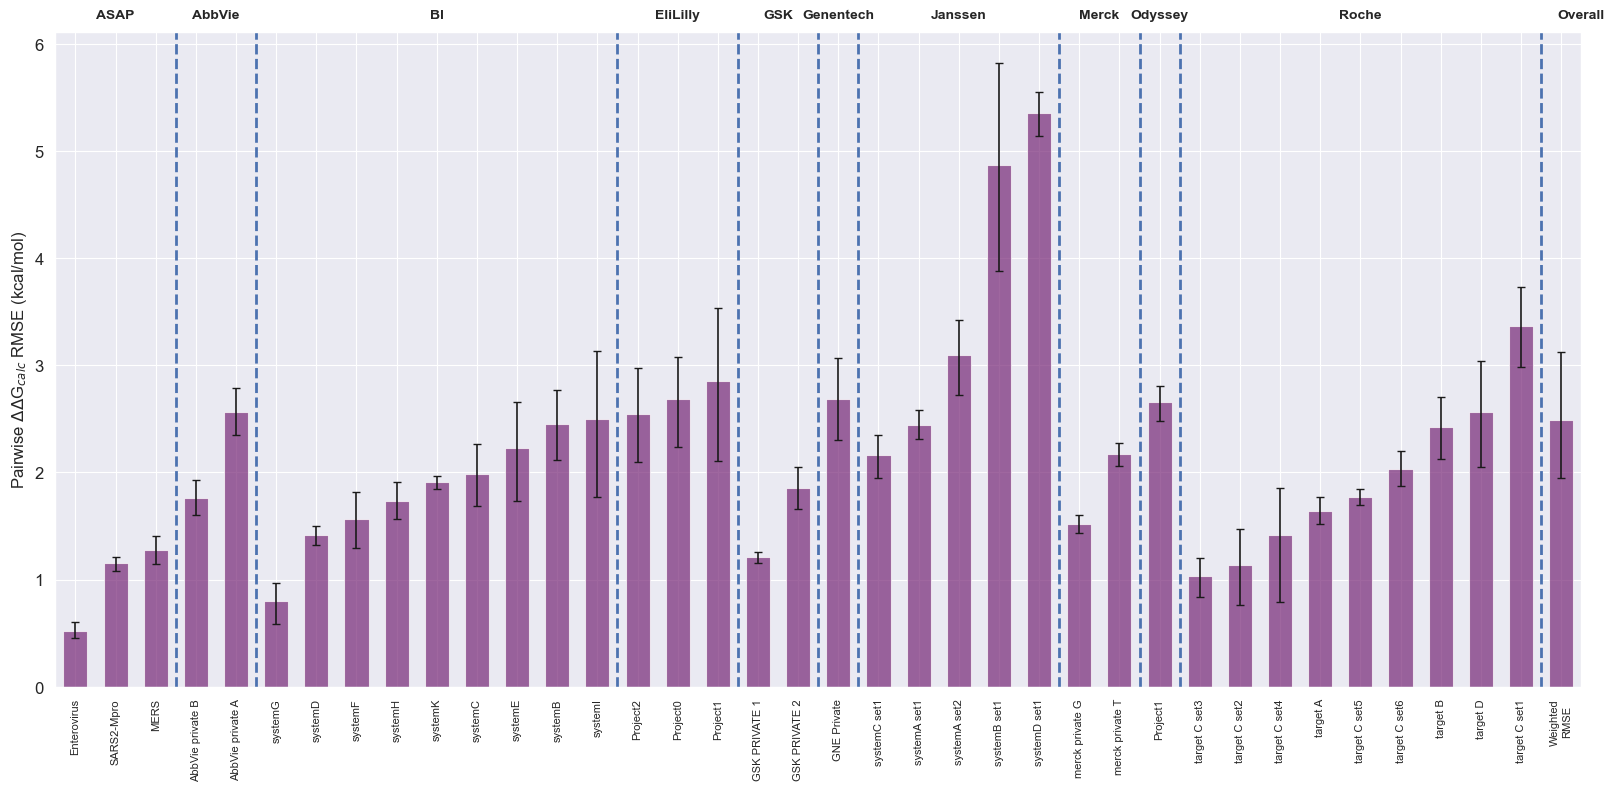

In [133]:
plot_pairwise_rmse(system_pairwise_rmse_private, "per_system_pairwise_rmse_private.png")

{'ASAP': 3, 'AbbVie': 5, 'BI': 14, 'EliLilly': 17, 'GSK': 19, 'Genentech': 20, 'Janssen': 25, 'Merck': 27, 'Odyssey': 28, 'Overall': 39, 'Roche': 37}


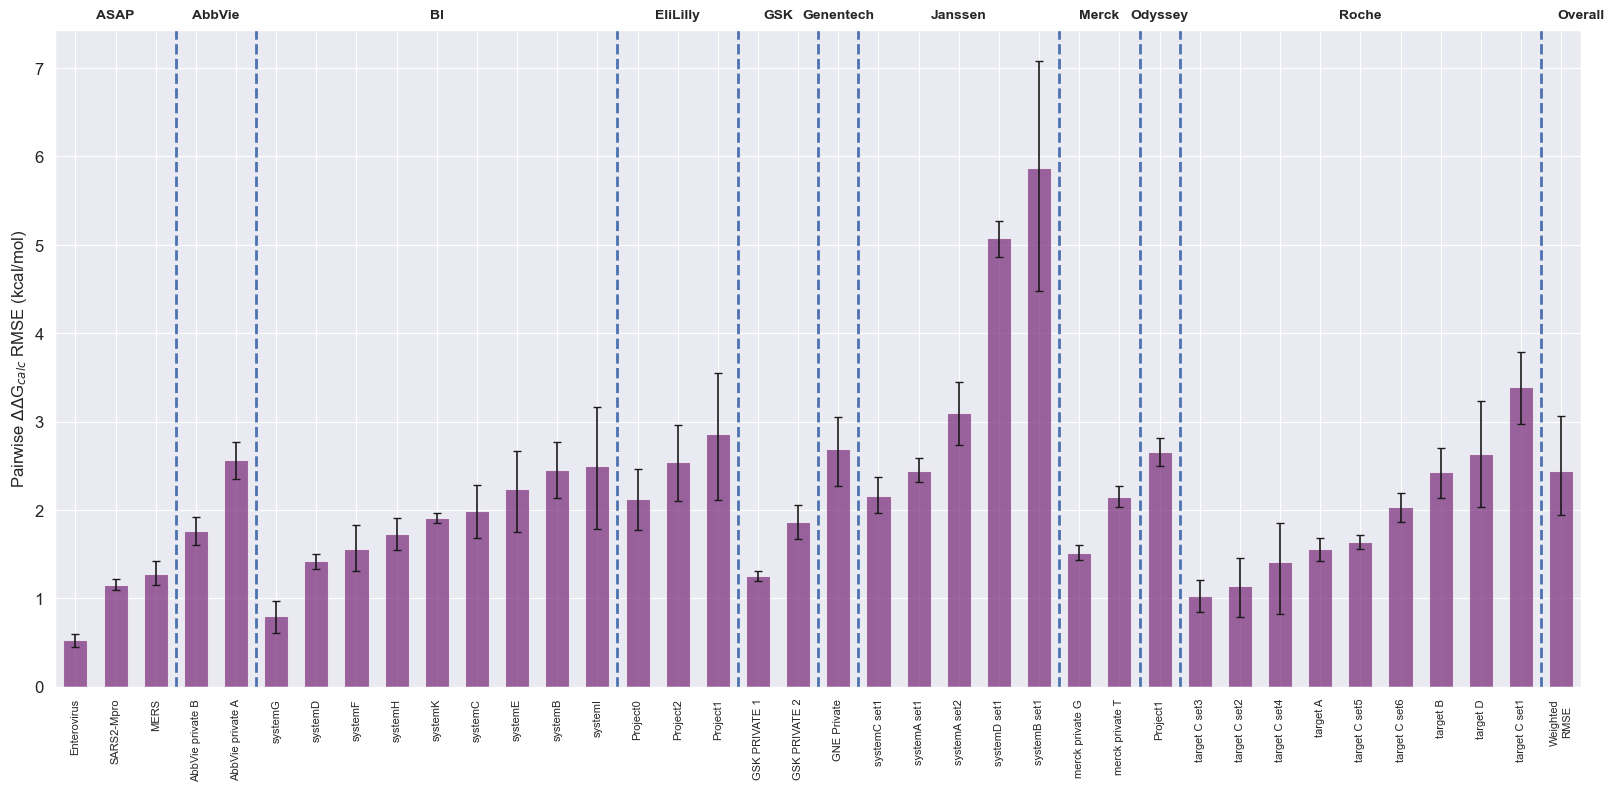

In [134]:
# plot again using the filtered private dataset
plot_pairwise_rmse(system_pairwise_rmse_private_filtered, "per_system_pairwise_rmse_filtered.png")

In [139]:
# plot the ecdfs of the pairwise differences for openfe
import numpy as np
def plot_pairwise_ecdf(df, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    # plot the ecdf for the public data
    # calculate the abs errors
    private_error = np.abs(df["OpenFE DDG (kcal/mol)"] - df["Exp DDG (kcal/mol)"])
    sns.ecdfplot(private_error, label="Private", ax=ax, color='#762776', alpha=0.7)
    # workout the percentage of values below 1 kcal/mol on the private data
    private_below_1 = np.sum(private_error < 1) / len(private_error) 
    # add a line at 1 kcal/mol for private
    ax.axvline(x=1, ymax=private_below_1, color='k', linestyle='--', linewidth=2)
    ax.plot([0, 1], [private_below_1, private_below_1], color='#762776', linestyle='--', linewidth=2, alpha=0.7)
    # add the text for the percentage below 1 kcal/mol
    ax.text(0.1, private_below_1 + 0.02, f"{private_below_1:.2%}", color='#762776', fontsize=13, zorder=10, alpha=0.7)
    # do the same for 2 kcal/mol
    private_below_2 = np.sum(private_error < 2) / len(private_error)
    ax.axvline(x=2, ymax=private_below_2, color='k', linestyle='--', linewidth=2)
    ax.plot([0, 2], [private_below_2, private_below_2], color='#762776', linestyle='--', linewidth=2, alpha=0.7)
    # add the text for the percentage below 2 kcal/mol
    ax.text(0.1, private_below_2 + 0.02, f"{private_below_2:.2%}", color='#762776', fontsize=13, alpha=0.7)
    # same again at 3 kcal/mol
    private_below_3 = np.sum(private_error < 3) / len(private_error)
    ax.axvline(x=3, ymax=private_below_3, color='k', linestyle='--', linewidth=2)
    ax.plot([0, 3], [private_below_3, private_below_3], color='#762776', linestyle='--', linewidth=2, alpha=0.7)
    ax.text(0.1, private_below_3 + 0.02, f"{private_below_3:.2%}", color='#762776', fontsize=13, alpha=0.7)
    # plot the ecdf for the private data
    # set the labels and title
    ax.set_xlabel(r"Pairwise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontdict={"fontsize": 15})
    ax.set_ylabel("Cumulative Probability", fontdict={"fontsize": 15})
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.xlim(left=0)
    # plt.legend()
    plt.tight_layout()
    return plt.savefig(filename, dpi=300, bbox_inches='tight')

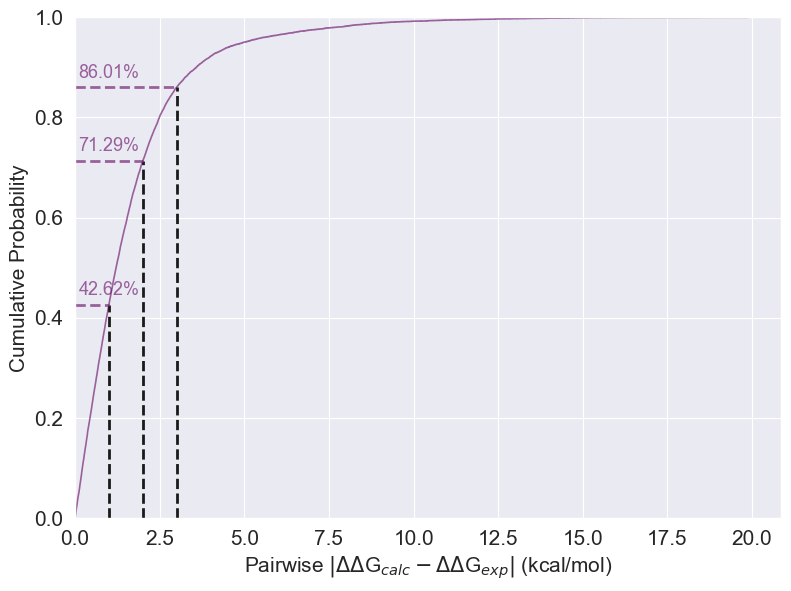

In [140]:
# plot the ecdf for the private data
plot_pairwise_ecdf(private_pairwise_diffs, "ecdf_pairwise_differences_private.png")

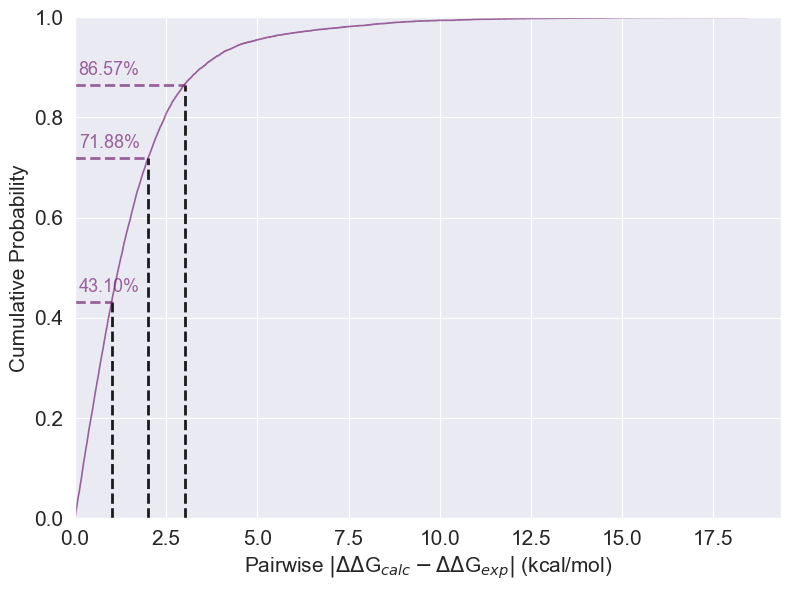

In [143]:
# plot for the filtered private dataset
plot_pairwise_ecdf(private_pariwise_diffs_filtered, "ecdf_pairwise_differences_private_filtered.png")

In [144]:
# find how many pairwise differences are above 10 kcal/mol in error on the private filtered dataset
private_error_filtered = np.abs(private_pariwise_diffs_filtered["OpenFE DDG (kcal/mol)"] - private_pariwise_diffs_filtered["Exp DDG (kcal/mol)"])
print("Number of pairwise differences above 10 kcal/mol in error:", np.sum(private_error_filtered > 10))
print("Percentage of pairwise differences above 10 kcal/mol in error:", np.sum(private_error_filtered > 10) / len(private_error_filtered) * 100)

Number of pairwise differences above 10 kcal/mol in error: 102
Percentage of pairwise differences above 10 kcal/mol in error: 0.6091734352603918


In [148]:
# count the number of pairwise differences above 10 kcal/mol in each system, is one system bad or is it distributed throughout the dataset?
high_error_counts = []
for system in private_pariwise_diffs_filtered["Class"].unique():
    system_df = private_pariwise_diffs_filtered[private_pariwise_diffs_filtered["Class"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_df["System"].unique():
        target_df = system_df[system_df["System"] == target].copy(deep=True).reset_index(drop=True)
        # count the number of pairwise differences above 10 kcal/mol
        n_above_10 = np.sum(np.abs(target_df["OpenFE DDG (kcal/mol)"] - target_df["Exp DDG (kcal/mol)"]) > 10)
        high_error_counts.append((system, target, n_above_10))
# sort the counts by the number of high errors
high_error_counts = sorted(high_error_counts, key=lambda x: x[2], reverse=True)
# print the top 10 systems with the most high errors
print("Top 10 systems with the most pairwise differences above 10 kcal/mol in error:")
for system, target, count in high_error_counts[:10]:
    print(f"{system} - {target}: {count} pairwise differences above 10 kcal/mol in error")

Top 10 systems with the most pairwise differences above 10 kcal/mol in error:
Janssen - systemD_set1: 79 pairwise differences above 10 kcal/mol in error
Janssen - systemB_set1: 10 pairwise differences above 10 kcal/mol in error
BI - systemK: 8 pairwise differences above 10 kcal/mol in error
Roche - target_C_set1: 5 pairwise differences above 10 kcal/mol in error
ASAP - Enterovirus: 0 pairwise differences above 10 kcal/mol in error
ASAP - MERS: 0 pairwise differences above 10 kcal/mol in error
ASAP - SARS2-Mpro: 0 pairwise differences above 10 kcal/mol in error
AbbVie - AbbVie_private_A: 0 pairwise differences above 10 kcal/mol in error
AbbVie - AbbVie_private_B: 0 pairwise differences above 10 kcal/mol in error
BI - systemB: 0 pairwise differences above 10 kcal/mol in error


In [163]:
# plot DG vs exp for Janssen systemD_set1 and Janssen systemB_set1 to see whats going on
def plot_dg_vs_exp(df, partner, system, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    system_df = df[(df["dataset_name"] == system) & (df["partner_id"] == partner)].copy(deep=True).reset_index(drop=True)
    sns.scatterplot(data=system_df, x="Exp DG (kcal/mol)", y="DG (kcal/mol)", ax=ax, color='#762776', alpha=0.7, label=system)
    # add a line at y=x
    ax.plot([system_df["Exp DG (kcal/mol)"].min(), system_df["Exp DG (kcal/mol)"].max()], 
            [system_df["Exp DG (kcal/mol)"].min(), system_df["Exp DG (kcal/mol)"].max()], 
            color='k', linestyle='--', linewidth=2)
    # set the labels and title
    plt.legend(fontsize=12)
    ax.set_xlabel(r"Experimental $\Delta\Delta$G (kcal/mol)", fontsize=14)
    ax.set_ylabel(r"Calculated $\Delta\Delta$G (kcal/mol)", fontsize=14)
    plt.tight_layout()
    return plt.savefig(filename, dpi=300, bbox_inches='tight')

In [164]:
private_dg_data_filtered

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name
0,unknown_ligand_3,-11.138621,0.112866,-11.295068,0.009218,ASAP,Enterovirus
1,unknown_ligand_15,-10.195037,0.097533,-10.146950,0.054278,ASAP,Enterovirus
2,unknown_ligand_7,-10.798933,0.098011,-10.678739,0.026163,ASAP,Enterovirus
3,unknown_ligand_21,-9.901235,0.152421,-9.819696,0.054102,ASAP,Enterovirus
4,unknown_ligand_19,-10.717638,0.365485,-9.915145,0.139450,ASAP,Enterovirus
...,...,...,...,...,...,...,...
837,ligand6,-9.455397,0.614779,-8.236271,0.000000,Roche,target_D
838,ligand3,-5.933406,0.715944,-5.933406,0.000000,Roche,target_D
839,ligand8,-6.682645,1.244110,-6.782175,0.000000,Roche,target_D
840,ligand5,-7.112522,1.238355,-5.933406,0.000000,Roche,target_D


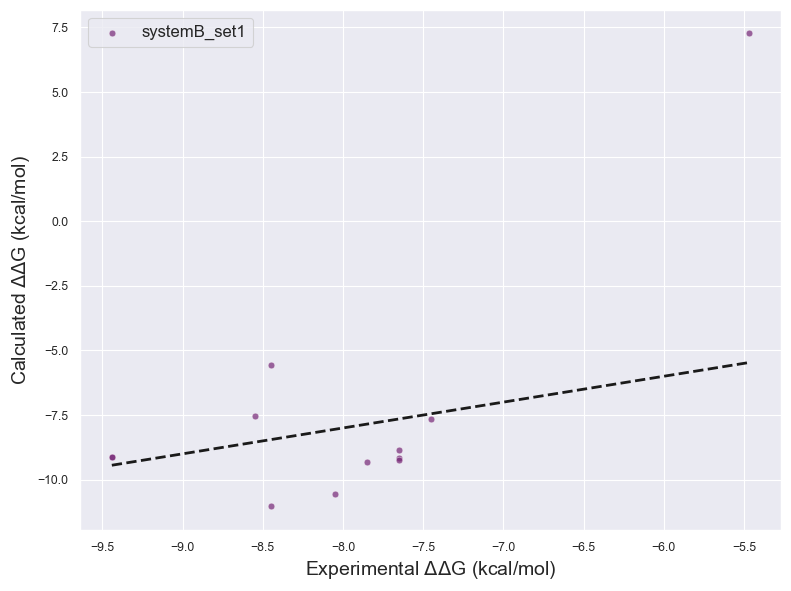

In [166]:
plot_dg_vs_exp(private_dg_data_filtered, "Janssen", "systemB_set1", "janssen_systemB_set1_dg_vs_exp.png")

In [150]:
# calculate the probability of the correct sign for the pairwise differences for the private data
def bin_sign_correctness(data, bin_size=1.0):
    """
    Bin the absolute experimental DDG values and calculate the probability of getting the sign correct.
    """
    # Create bins
    data['abs_exp_ddg'] = np.abs(data['Exp DDG (kcal/mol)'])
    # max value
    max_value = data['abs_exp_ddg'].max()
    bins = np.arange(0, max_value + bin_size, bin_size)
    
    # Bin the data
    data['bin'] = pd.cut(data['abs_exp_ddg'], bins=bins, right=False)
    
    # Calculate probabilities
    results = []
    # sort the bins by the lower edge
    for b in sorted(data['bin'].unique(), key=lambda x: x.left):
        subset = data[data['bin'] == b]
        if len(subset) == 0:
            continue
        # Calculate the probability of correct sign for OpenFE and FEP+ and bootstrap the results
        openfe_correct = np.sum(np.sign(subset['OpenFE DDG (kcal/mol)']) == np.sign(subset['Exp DDG (kcal/mol)']))
        total = len(subset)
        # Bootstrap the probabilities
        nboots = 1000
        openfe_probs = []
        for _ in range(nboots):
            bootstrapped_subset = subset.sample(n=len(subset), replace=True)
            openfe_correct_boot = np.sum(np.sign(bootstrapped_subset['OpenFE DDG (kcal/mol)']) == np.sign(bootstrapped_subset['Exp DDG (kcal/mol)']))
            total_boot = len(bootstrapped_subset)
            openfe_probs.append(openfe_correct_boot / total_boot)
        # Calculate mean and 95% CI
        openfe_mean = np.mean(openfe_probs)
        openfe_low = np.percentile(openfe_probs, 2.5)
        openfe_high = np.percentile(openfe_probs, 97.5)
        # store the results so we can use hue to split the data
        results.append({
            'bin': b.left,
            'OpenFE Probability': openfe_mean,
            'OpenFE Probability Lower': openfe_low,
            'OpenFE Probability Upper': openfe_high,
        })
        # x+=1
    return pd.DataFrame(results)
# Calculate the binned probabilities
binned_probabilities_private = bin_sign_correctness(private_pairwise_diffs, bin_size=0.5)
binned_probabilities_private_filtered = bin_sign_correctness(private_pariwise_diffs_filtered, bin_size=0.5)

In [153]:

# Plot the binned probabilities using a bar plot with error bars
def plot_sign_correct(df, filename):
    fig, ax = plt.subplots(figsize=(10, 6))
    binned = df.copy(deep=True)
    # add padding data for the missing bins
    all_bins = binned['bin'].unique()
    # sort the bins
    sorted_bins = np.sort(all_bins)
    new_bins = np.arange(0, sorted_bins.max() + 0.5, 0.5)
    data_to_add = []
    for b in new_bins:
        if b not in sorted_bins:
            data_to_add.append({
                'bin': b,
                'OpenFE Probability': np.nan,
                'OpenFE Probability Lower': np.nan,
                'OpenFE Probability Upper': np.nan
            })
    binned_probabilities = pd.concat([df, pd.DataFrame(data_to_add)], ignore_index=True)
    sns.barplot(data=binned_probabilities, x='bin', y='OpenFE Probability', ax=ax, color='#762776', width=1.0, alpha=0.7)
    # add error bars for the probabilities
    ax.set_xlabel(r"|$\Delta\Delta$G$_{exp}$| (kcal/mol)", fontsize=14)
    ax.set_ylabel(r"Probability Correct pairwise $\Delta\Delta$G$_{calc}$ Sign", fontsize=14)
    # set the x ticks to go from 0 to the max bin value in 1 kcal/mol increments
    x_ticks = np.arange(1.5, 20.5, 2)
    ax.errorbar(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'],
                yerr=[binned_probabilities['OpenFE Probability'] - binned_probabilities['OpenFE Probability Lower'],
                    binned_probabilities['OpenFE Probability Upper'] - binned_probabilities['OpenFE Probability']],
                fmt='none', color='black', capsize=5)
    # add scatter points for the probabilities
    ax.scatter(binned_probabilities['bin'] *2, binned_probabilities['OpenFE Probability'], color='#762776', edgecolor='black', s=50, alpha=0.7)
    print(x_ticks)
    print(ax.get_xticks())
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.ylim(bottom=0.4)
    plt.xlim(left=-0.5)
    return plt.savefig(filename, dpi=300, bbox_inches='tight')

[ 1.5  3.5  5.5  7.5  9.5 11.5 13.5 15.5 17.5 19.5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


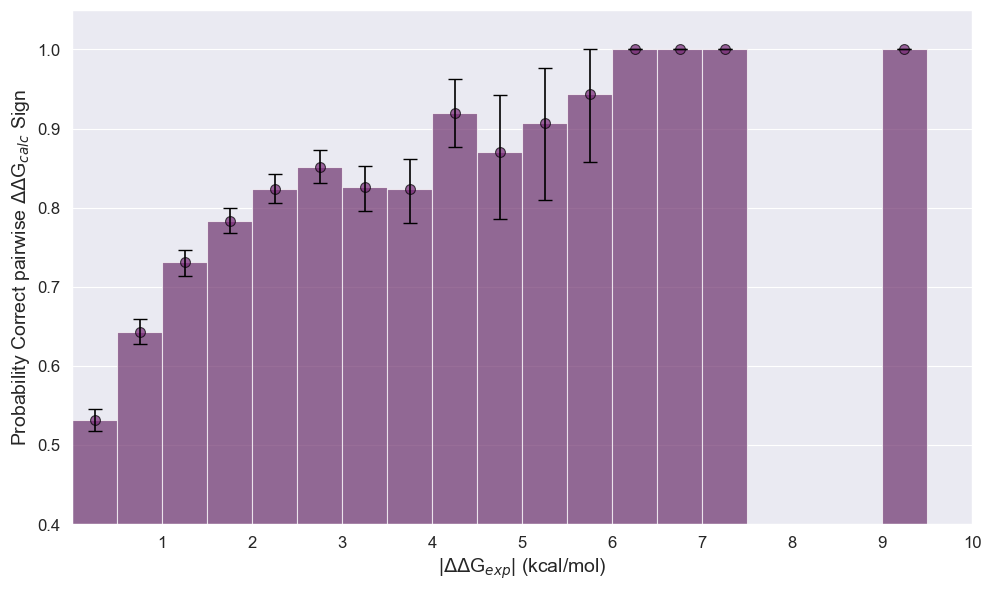

In [154]:
# plot the signed correctness for the private data
plot_sign_correct(binned_probabilities_private, "binned_probabilities_private.png")

[ 1.5  3.5  5.5  7.5  9.5 11.5 13.5 15.5 17.5 19.5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


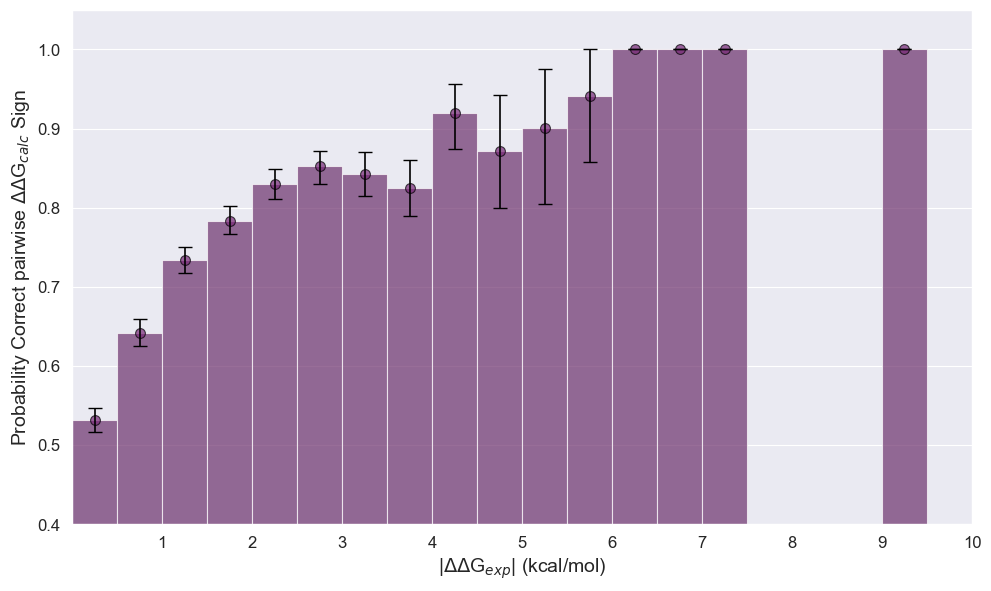

In [155]:
plot_sign_correct(binned_probabilities_private_filtered, "binned_probabilities_private_filtered.png")

In [186]:
# calculate the edgewise errors for the private data
# first create a new datarame after removing edges involved in the issues above
private_edge_data_filtered = []
for _, row in private_edge_data.iterrows():
    # only keep edges with experimental values
    if pd.isna(row["exp DDG (kcal/mol)"]):
        continue
    if (row["partner_id"], row["dataset_name"]) not in issue_ligands:
        private_edge_data_filtered.append(row.to_dict())
    else:
        issues = issue_ligands[(row["partner_id"], row["dataset_name"])]
        # get a single list of ligands that are issues
        issue_ligs = [lig for lig in issues.values() for lig in lig]
        if row["ligand_A"] in issue_ligs or row["ligand_B"] in issue_ligs:
            continue
        # if the row is not an issue, append it to the new list
        private_edge_data_filtered.append(row.to_dict())
private_edge_data_filtered = pd.DataFrame(private_edge_data_filtered)
private_edge_data_filtered

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_dDG (kcal/mol),complex_repeat_1_com_drift_max,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed
0,unknown_ligand_3,unknown_ligand_15,0.904837,0,1.0,0.046432,1.000000,0.761981,20,1,...,0.024560,1.615484,2.155722,1.030558e-01,-0.601893,0.025645,1.976220,3.056871,1.036430e-01,NaN
1,unknown_ligand_15,unknown_ligand_21,0.904837,0,1.0,0.046591,1.000000,0.762179,20,0,...,0.036440,2.341021,3.475891,1.101982e-01,1.370174,0.035461,2.180326,3.084103,1.067604e-01,NaN
2,unknown_ligand_4,unknown_ligand_7,0.704688,0,1.0,0.067010,0.897792,0.930257,21,3,...,0.064892,1.916821,3.366926,1.514569e-01,1.907094,0.062430,1.777632,2.724484,1.506563e-01,NaN
3,unknown_ligand_4,unknown_ligand_16,0.740818,0,1.0,0.066640,0.929515,0.858519,24,0,...,0.067347,2.279704,2.835818,1.135390e-01,12.684880,0.065316,2.026167,2.729386,1.128227e-01,NaN
4,unknown_ligand_12,unknown_ligand_18,0.606531,0,1.0,0.149838,0.854168,0.746158,19,1,...,0.101551,2.153230,2.614514,8.345317e-02,-1.503679,0.091161,2.141610,2.594715,8.289452e-02,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1243,ligand10,ligand11,0.000611,0,1.0,0.456418,0.027447,0.387492,10,42,...,922.256541,112.736137,112.749619,1.050534e-08,105.463073,274.688304,118.508476,118.640388,3.747174e-08,NaN
1244,ligand6,ligand12,0.025991,0,1.0,0.312449,0.367474,0.303209,25,12,...,0.326187,119.498550,119.725906,1.034615e-02,75.711872,0.362753,126.437271,126.461586,2.033600e-02,NaN
1245,ligand11,ligand12,0.020242,0,1.0,0.205950,0.405952,0.895260,26,16,...,0.439065,125.984756,126.013779,8.125007e-03,-152.669851,0.600160,111.879089,111.980225,2.786875e-03,NaN
1246,ligand0,ligand11,0.030197,0,1.0,0.193953,0.406137,0.942570,26,9,...,0.433521,118.773781,118.922112,1.268440e-02,114.461670,0.266555,120.105179,120.169167,1.272901e-02,NaN


In [187]:
private_edge_data_filtered.columns

Index(['ligand_A', 'ligand_B', 'lomap_score', 'alchemical_charge_difference',
       'charge_score', 'shape_score', 'volume_score', 'mapping_rmsd_score',
       'num_heavy_core', 'num_heavy_dummy_A', 'num_heavy_dummy_B',
       'difference_num_rings_AB', 'difference_num_rot_bonds_AB',
       'morgan_tanimoto_similarity',
       'difference_solvent_accessible_surface_area',
       'atom_pair_dice_similarity', 'topological_torsion_dice_similarity',
       'dataset_name', 'partner_id', 'exp DDG (kcal/mol)',
       'exp dDDG (kcal/mol)', 'solvent_repeat_0_DG (kcal/mol)',
       'solvent_repeat_0_dDG (kcal/mol)', 'solvent_repeat_0_com_drift_max',
       'solvent_repeat_0_ligand_rmsd_max', 'solvent_repeat_0_smallest_overlap',
       'solvent_repeat_1_DG (kcal/mol)', 'solvent_repeat_1_dDG (kcal/mol)',
       'solvent_repeat_1_com_drift_max', 'solvent_repeat_1_ligand_rmsd_max',
       'solvent_repeat_1_smallest_overlap', 'solvent_repeat_2_DG (kcal/mol)',
       'solvent_repeat_2_dDG (kcal/mol)

In [188]:
from cinnabar.stats import bootstrap_statistic
def calculate_edgewise_errors_private(df):
    # calculate the RMSE and MUE error for the edgewise data
    complex_data = df[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    solvent_data = df[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
    # calculate the mean and std for the complex and solvent data
    complex_mean = complex_data.mean(axis=1)
    complex_std = complex_data.std(axis=1)
    solvent_mean = solvent_data.mean(axis=1)
    solvent_std = solvent_data.std(axis=1)
    # calculate the edgewise errors
    ddg = complex_mean - solvent_mean
    ddg_error = np.sqrt(complex_std**2 + solvent_std**2)
    all_results = []
    for stat in ["RMSE", "MUE"]:
        s = bootstrap_statistic(y_true=df["exp DDG (kcal/mol)"], y_pred=ddg, statistic=stat, nbootstrap=1000)
        all_results.append({
            "Metric": stat,
            "Value": s["mle"],
            "Low": s["low"],
            "High": s["high"],
        })
    return pd.DataFrame(all_results)

In [189]:
private_edgewise_errors = calculate_edgewise_errors_private(private_edge_data_filtered)
private_edgewise_errors

,Metric,Value,Low,High
0,RMSE,1.934822,1.797812,2.082127
1,MUE,1.373505,1.299176,1.449695


In [191]:
private_edge_data_filtered.columns

Index(['ligand_A', 'ligand_B', 'lomap_score', 'alchemical_charge_difference',
       'charge_score', 'shape_score', 'volume_score', 'mapping_rmsd_score',
       'num_heavy_core', 'num_heavy_dummy_A', 'num_heavy_dummy_B',
       'difference_num_rings_AB', 'difference_num_rot_bonds_AB',
       'morgan_tanimoto_similarity',
       'difference_solvent_accessible_surface_area',
       'atom_pair_dice_similarity', 'topological_torsion_dice_similarity',
       'dataset_name', 'partner_id', 'exp DDG (kcal/mol)',
       'exp dDDG (kcal/mol)', 'solvent_repeat_0_DG (kcal/mol)',
       'solvent_repeat_0_dDG (kcal/mol)', 'solvent_repeat_0_com_drift_max',
       'solvent_repeat_0_ligand_rmsd_max', 'solvent_repeat_0_smallest_overlap',
       'solvent_repeat_1_DG (kcal/mol)', 'solvent_repeat_1_dDG (kcal/mol)',
       'solvent_repeat_1_com_drift_max', 'solvent_repeat_1_ligand_rmsd_max',
       'solvent_repeat_1_smallest_overlap', 'solvent_repeat_2_DG (kcal/mol)',
       'solvent_repeat_2_dDG (kcal/mol)

In [200]:
# plot an ecdf of the absolute edgewise errors for the filtered private data and public data
def plot_edgewise_ecdf(df_private, df_public, filename):
    fig, ax = plt.subplots(figsize=(8, 6))
    # plot the ecdf for the public data
    # calculate the abs errors
    for (dataset, colour, label) in [(df_public, "#009384", "Public"), (df_private, "#762776", "Private")]:
        complex_data = dataset[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
        solvent_data = dataset[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
        # calculate the mean and std for the complex and solvent data
        complex_mean = complex_data.mean(axis=1)
        solvent_mean = solvent_data.mean(axis=1)
        ddg = complex_mean - solvent_mean
        error = np.abs(ddg - dataset["exp DDG (kcal/mol)"])
        sns.ecdfplot(error, label=label, ax=ax, color=colour, alpha=0.7)
        # workout the percentage of values below 1 kcal/mol on the private data
        below_1 = np.sum(error < 1) / len(error) 
        # add a line at 1 kcal/mol for private
        ax.axvline(x=1, ymax=below_1, color='k', linestyle='--', linewidth=2)
        ax.plot([0, 1], [below_1, below_1], color=colour, linestyle='--', linewidth=2, alpha=0.7)
        # add the text for the percentage below 1 kcal/mol
        ax.text(0.1, below_1 + 0.02, f"{below_1:.2%}", color=colour, fontsize=13, zorder=10, alpha=0.7)
        # do the same for 2 kcal/mol
        below_2 = np.sum(error < 2) / len(error)
        ax.axvline(x=2, ymax=below_2, color='k', linestyle='--', linewidth=2)
        ax.plot([0, 2], [below_2, below_2], color=colour, linestyle='--', linewidth=2, alpha=0.7)
        # add the text for the percentage below 2 kcal/mol
        ax.text(0.1, below_2 + 0.02, f"{below_2:.2%}", color=colour, fontsize=13, alpha=0.7)
        # same again at 3 kcal/mol
        # below_3 = np.sum(error < 3) / len(error)
        # ax.axvline(x=3, ymax=below_3, color='k', linestyle='--', linewidth=2)
        # ax.plot([0, 3], [below_3, below_3], color=colour, linestyle='--', linewidth=2, alpha=0.7)
        # ax.text(0.1, below_3 + 0.02, f"{below_3:.2%}", color=colour, fontsize=13, alpha=0.7)
    # plot the ecdf for the private data
    # set the labels and title
    ax.set_xlabel(r"Edgewise $|\Delta\Delta$G$_{calc}-\Delta\Delta$G$_{exp}|$ (kcal/mol)", fontdict={"fontsize": 15})
    ax.set_ylabel("Cumulative Probability", fontdict={"fontsize": 15})
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    plt.legend(fontsize=12)
    plt.xlim(left=0)
    # plt.legend()
    plt.tight_layout()
    return plt.savefig(filename, dpi=300, bbox_inches='tight')

In [201]:
# get all the public edge data where experimental values
public_edge_data = normal_edge_data[normal_edge_data["exp DDG (kcal/mol)"].notna()].copy(deep=True).reset_index(drop=True)
public_edge_data

,ligand_A,ligand_B,lomap_score,alchemical_charge_difference,charge_score,shape_score,volume_score,mapping_rmsd_score,num_heavy_core,num_heavy_dummy_A,...,complex_repeat_1_ligand_rmsd_max,complex_repeat_1_smallest_overlap,complex_repeat_2_DG (kcal/mol),complex_repeat_2_dDG (kcal/mol),complex_repeat_2_com_drift_max,complex_repeat_2_ligand_rmsd_max,complex_repeat_2_smallest_overlap,failed,system group,system name
0,34,25,0.670320,0,1.000000,0.057515,0.966424,0.730672,25,2,...,28.411707,0.110235,27.245596,0.113900,3.984440,4.468362,0.111000,NaN,charge_annihilation_set,cdk2
1,39charg,34,0.000000,-1,0.614286,0.012182,0.980239,0.988664,27,0,...,32.545681,0.207117,-21.401634,0.074439,31.848991,32.294037,0.206549,NaN,charge_annihilation_set,cdk2
2,39charg,25,0.000000,-1,0.614286,0.045757,0.985675,0.724526,25,2,...,29.240601,0.198225,17.934588,0.088183,31.980310,32.360592,0.198287,NaN,charge_annihilation_set,cdk2
3,17charg,8,0.223130,0,1.000000,0.143513,0.445382,0.996009,19,9,...,4.466974,0.022621,-3.680717,0.204893,3.250983,4.278775,0.022991,NaN,charge_annihilation_set,dlk
4,4charg,8,0.246597,0,1.000000,0.048722,0.579467,1.000000,20,3,...,3.812082,0.138050,4.873596,0.068123,3.571454,4.066833,0.134652,NaN,charge_annihilation_set,dlk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1176,49,47,0.860708,0,1.000000,0.074540,0.937613,0.653421,28,0,...,68.239609,0.098195,5.025639,0.083096,47.049469,68.496689,0.104164,NaN,merck,pfkfb3
1177,65,29,0.704688,0,1.000000,0.155796,0.895401,0.484258,30,0,...,67.026726,0.157674,-83.240725,0.102459,29.012836,53.727703,0.160825,NaN,merck,pfkfb3
1178,29,64,0.778801,0,1.000000,0.155630,0.895401,0.462020,30,1,...,54.050873,0.165275,86.337561,0.101216,46.250511,68.017464,0.164021,NaN,merck,pfkfb3
1179,47,46,0.548812,0,1.000000,0.202290,0.735485,0.305883,27,2,...,52.765472,0.133457,-11.214751,0.046477,43.071308,66.045006,0.131496,NaN,merck,pfkfb3


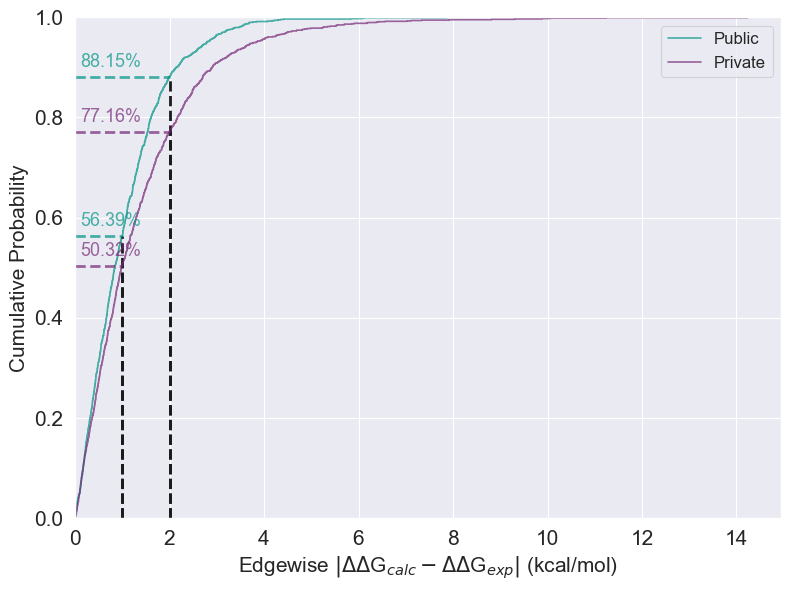

In [202]:
plot_edgewise_ecdf(private_edge_data_filtered, public_edge_data, "ecdf_edgewise_differences_pub_private.png")

In [210]:
# find the high error edges in the private filtered dataset
private_complex_data = private_edge_data_filtered[[f"complex_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
private_solvent_data = private_edge_data_filtered[[f"solvent_repeat_{i}_DG (kcal/mol)" for i in range(3)]]
# calculate the mean and std for the complex and solvent data
private_complex_mean = private_complex_data.mean(axis=1)
private_complex_error = private_complex_data.std(axis=1)
private_solvent_mean = private_solvent_data.mean(axis=1)
private_solvent_error = private_solvent_data.std(axis=1)
# calculate the edgewise errors
private_ddg = private_complex_mean - private_solvent_mean
private_ddg_error = np.sqrt(private_complex_error**2 + private_solvent_error**2)
private_edge_data_filtered["calc DDG (kcal/mol)"] = private_ddg
private_edge_data_filtered["calc dDDG (kcal/mol)"] = private_ddg_error
private_error = np.abs(private_ddg - private_edge_data_filtered["exp DDG (kcal/mol)"])
# add to the dataframe and sort by error
private_edge_data_filtered["abs_error"] = private_error
# sort by error
private_edge_data_filtered.sort_values(by="abs_error", ascending=False, inplace=True)
# get the top 10 edges with the highest error
high_error_edges = private_edge_data_filtered.head(10)
# print the high error edges
print("Top 10 edges with the highest error in the private filtered dataset:")
for _, row in high_error_edges.iterrows():
    print(f"{row['partner_id']} - {row['dataset_name']} - {row['ligand_A']} - {row['ligand_B']}: {row['abs_error']:.2f} kcal/mol predicted {row['calc DDG (kcal/mol)']:.2f} kcal/mol, experimental {row['exp DDG (kcal/mol)']:.2f} kcal/mol uncertainty {row['calc dDDG (kcal/mol)']:.2f} kcal/mol")


Top 10 edges with the highest error in the private filtered dataset:
Janssen - systemB_set1 - ligand11 - ligand13: 14.23 kcal/mol predicted 16.62 kcal/mol, experimental 2.39 kcal/mol uncertainty 0.81 kcal/mol
Janssen - systemB_set1 - ligand13 - ligand14: 11.24 kcal/mol predicted -14.32 kcal/mol, experimental -3.08 kcal/mol uncertainty 2.74 kcal/mol
Roche - target_D - ligand10 - ligand4: 10.05 kcal/mol predicted -5.06 kcal/mol, experimental 4.99 kcal/mol uncertainty 2.15 kcal/mol
Roche - target_C_set1 - ligand7 - ligand12: 9.88 kcal/mol predicted 17.38 kcal/mol, experimental 7.50 kcal/mol uncertainty 1.93 kcal/mol
Janssen - systemD_set1 - ligand55 - ligand51: 9.31 kcal/mol predicted 6.33 kcal/mol, experimental -2.98 kcal/mol uncertainty 0.97 kcal/mol
Janssen - systemD_set1 - ligand43 - ligand37: 8.82 kcal/mol predicted 7.92 kcal/mol, experimental -0.90 kcal/mol uncertainty 0.66 kcal/mol
Janssen - systemD_set1 - ligand55 - ligand37: 7.91 kcal/mol predicted 4.93 kcal/mol, experimental -2.

In [205]:
# pull out the error systems 
jan_systemB_set1 = private_dg_data_filtered[(private_dg_data_filtered["partner_id"] == "Janssen") & (private_dg_data_filtered["dataset_name"] == "systemB_set1")].copy(deep=True).reset_index(drop=True)
jan_systemB_set1

,ligand name,DG (kcal/mol),uncertainty (kcal/mol),Exp DG (kcal/mol),Exp dDG (kcal/mol),partner_id,dataset_name
0,ligand12,-9.143549,0.333137,-7.652511,0.0,Janssen,systemB_set1
1,ligand8,-8.859269,0.185925,-7.652511,0.0,Janssen,systemB_set1
2,ligand2,-5.578839,1.418129,-8.447591,0.0,Janssen,systemB_set1
3,ligand5,-11.028508,0.261597,-8.447591,0.0,Janssen,systemB_set1
4,ligand3,-7.642153,0.152438,-7.453742,0.0,Janssen,systemB_set1
5,ligand9,-9.221645,0.170777,-7.652511,0.0,Janssen,systemB_set1
6,ligand14,-7.529890,0.157431,-8.546953,0.0,Janssen,systemB_set1
7,ligand16,-9.116828,0.502641,-9.441213,0.0,Janssen,systemB_set1
8,ligand15,-9.116827,0.502641,-9.441213,0.0,Janssen,systemB_set1
9,ligand11,-9.317719,0.197240,-7.851283,0.0,Janssen,systemB_set1


In [209]:
# drop the outlier ligand and calculate the all-to-all pairwise differences again
jan_systemB_set1_filtered = jan_systemB_set1[jan_systemB_set1["ligand name"] != "ligand13"].copy(deep=True).reset_index(drop=True)
jan_systemB_set1_filtered_pairwise_diffs = calc_pairwise_differences(jan_systemB_set1_filtered, public=False)
rmse = ((jan_systemB_set1_filtered_pairwise_diffs["OpenFE DDG (kcal/mol)"] - jan_systemB_set1_filtered_pairwise_diffs["Exp DDG (kcal/mol)"]) ** 2).mean() ** 0.5
print(rmse)

2.3204932610562854


In [211]:
system_pairwise_rmse_private_filtered

,System,RMSE (kcal/mol),RMSE lower,RMSE upper,Class,n ligands
0,Enterovirus,0.524083,0.444276,0.600154,ASAP,12
1,SARS2-Mpro,1.151874,1.089202,1.221270,ASAP,33
2,MERS,1.279480,1.154452,1.421495,ASAP,15
3,AbbVie_private_B,1.761375,1.600329,1.914923,AbbVie,19
4,AbbVie_private_A,2.566835,2.351951,2.773952,AbbVie,19
5,systemG,0.800179,0.609540,0.966401,BI,6
6,systemD,1.417986,1.326448,1.501112,BI,29
7,systemF,1.563165,1.312444,1.825626,BI,12
8,systemH,1.730933,1.548993,1.913955,BI,16
9,systemK,1.906495,1.851251,1.960409,BI,120


In [212]:
private_pariwise_diffs_filtered

,System,Class,Ligand 1,Ligand 2,Exp DDG (kcal/mol),OpenFE DDG (kcal/mol),abs_exp_ddg,bin
0,Enterovirus,ASAP,unknown_ligand_3,unknown_ligand_15,1.148118,0.943584,1.148118,"[1.0, 1.5)"
1,Enterovirus,ASAP,unknown_ligand_3,unknown_ligand_7,0.616329,0.339688,0.616329,"[0.5, 1.0)"
2,Enterovirus,ASAP,unknown_ligand_3,unknown_ligand_21,1.475373,1.237386,1.475373,"[1.0, 1.5)"
3,Enterovirus,ASAP,unknown_ligand_3,unknown_ligand_19,1.379923,0.420983,1.379923,"[1.0, 1.5)"
4,Enterovirus,ASAP,unknown_ligand_3,unknown_ligand_20,1.393559,0.927374,1.393559,"[1.0, 1.5)"
...,...,...,...,...,...,...,...,...
16739,target_D,Roche,ligand3,ligand5,0.000000,-1.179116,0.000000,"[0.0, 0.5)"
16740,target_D,Roche,ligand3,ligand10,-5.940092,-0.794200,5.940092,"[5.5, 6.0)"
16741,target_D,Roche,ligand8,ligand5,0.848769,-0.429877,0.848769,"[0.5, 1.0)"
16742,target_D,Roche,ligand8,ligand10,-5.091323,-0.044961,5.091323,"[5.0, 5.5)"


In [217]:
def calculate_rmse_mue(calculated, experimental):
    """
    Calculate the RMSE and MUE between calculated and experimental values.
    """
    for stat in ["RMSE", "MUE"]:
        s = bootstrap_statistic(y_true=experimental, y_pred=calculated, statistic=stat, nbootstrap=1000)
        print(f"{stat} for the filtered private dataset: {s['mle']:.2f} kcal/mol ({s['low']:.2f} - {s['high']:.2f}) kcal/mol")

In [ ]:
# calculate the RMSE and MUE for the all-to-all pariwise differences for the filtered private dataset

predictions = private_pariwise_diffs_filtered["OpenFE DDG (kcal/mol)"].values
exp_values = private_pariwise_diffs_filtered["Exp DDG (kcal/mol)"].values
for stat in ["RMSE", "MUE"]:
    s = bootstrap_statistic(y_true=exp_values, y_pred=predictions, statistic=stat, nbootstrap=1000)
    print(f"{stat} for the filtered private dataset: {s['mle']:.2f} kcal/mol ({s['low']:.2f} - {s['high']:.2f}) kcal/mol")

RMSE for the filtered private dataset: 2.41 kcal/mol (2.36 - 2.46) kcal/mol
MUE for the filtered private dataset: 1.66 kcal/mol (1.63 - 1.69) kcal/mol


In [218]:
# calculate the edgewise RMSE and MUE for the filtered private dataset
edge_predictions = private_edge_data_filtered["calc DDG (kcal/mol)"].values
edge_exp_values = private_edge_data_filtered["exp DDG (kcal/mol)"].values
calculate_rmse_mue(edge_predictions, edge_exp_values)

RMSE for the filtered private dataset: 1.93 kcal/mol (1.78 - 2.08) kcal/mol
MUE for the filtered private dataset: 1.37 kcal/mol (1.30 - 1.45) kcal/mol


In [216]:
# get the number of eges in the comparison
len(private_edge_data_filtered)

1248

In [220]:
# split out the charged and neutral edges for the private filtered dataset
neutral_edge_data_filtered = private_edge_data_filtered[private_edge_data_filtered["alchemical_charge_difference"] == 0].copy(deep=True).reset_index(drop=True)
charged_edge_data_filtered = private_edge_data_filtered[private_edge_data_filtered["alchemical_charge_difference"] != 0].copy(deep=True).reset_index(drop=True)

In [221]:
len(neutral_edge_data_filtered), len(charged_edge_data_filtered)

(1238, 10)

In [222]:
calculate_rmse_mue(neutral_edge_data_filtered["calc DDG (kcal/mol)"].values, neutral_edge_data_filtered["exp DDG (kcal/mol)"].values)

RMSE for the filtered private dataset: 1.93 kcal/mol (1.79 - 2.09) kcal/mol
MUE for the filtered private dataset: 1.37 kcal/mol (1.29 - 1.45) kcal/mol


In [223]:
calculate_rmse_mue(charged_edge_data_filtered["calc DDG (kcal/mol)"].values, charged_edge_data_filtered["exp DDG (kcal/mol)"].values)

RMSE for the filtered private dataset: 2.32 kcal/mol (1.21 - 3.22) kcal/mol
MUE for the filtered private dataset: 1.84 kcal/mol (1.03 - 2.75) kcal/mol


In [ ]:
# plot the inter repeat range in the DDG predictions as an ecdf
fig, ax = plt.subplots(figsize=(8, 6))
for dataset, label in [(normal_edge_data, "Public"), (private_edge_data, "Private")]:
    all_ranges = []
    good_overlap = []
    for _, row in dataset.iterrows():
        data = []
        # get the overlaps for the solvent and complex repeats
        overlaps = [row[f"solvent_repeat_{i}_smallest_overlap"] for i in range(3)]
        for i in range(3):
            overlaps.append(row[f"complex_repeat_{i}_smallest_overlap"])

        # calculate the ddg for each repeat
        for i in range(3):
            ddg = row[f"complex_repeat_{i}_DG (kcal/mol)"] - row[f"solvent_repeat_{i}_DG (kcal/mol)"]
            data.append(ddg)

        ddg_range = max(data) - min(data)
        # append the range to the all_ranges list
        all_ranges.append(ddg_range)
        # if the overlaps are all greater than 0.03, append the ddg_range to the good_overlap list
        if min(overlaps) >= 0.03:
            good_overlap.append(max(data) - min(data))

    # workout the percentage of edges with a repeat range less than 1 kcal/mol
    all_ranges = np.array(all_ranges)
    good_overlap = np.array(good_overlap)
    below_1 = np.sum(all_ranges < 1) / len(all_ranges)
    below_1_overlap = np.sum(good_overlap < 1) / len(good_overlap)
    print(f"{label} - Percentage of edges with repeat range < 1 kcal/mol: {below_1:.2%}")
    print(f"{label} - Percentage of edges with repeat range < 1 kcal/mol and overlap > 0.03: {below_1_overlap:.2%}")
    # remove the outlier values from the all_ranges
    colour = sns.color_palette()[0] if label == "Public" else sns.color_palette()[1]
    all_ranges = [x for x in all_ranges if x < 300]  # filter out values greater than 300
    sns.ecdfplot(all_ranges, ax=ax, label=f"{label}-all", linewidth=2, color=colour)
    # plot with the same colour but dash line for good overlap
    good_overlap = [x for x in good_overlap if x < 300]  # filter out values greater than 300
    sns.ecdfplot(good_overlap, ax=ax, label=f"{label}-overlap > 0.03", linestyle='--', linewidth=2, color=colour)
ax.set_xlabel(r"|$\Delta\Delta$G$_{calc}$| repeat range (kcal/mol)", fontsize=12)
ax.set_ylabel("Cumulative Probability", fontsize=12)
# set the axis ticks fontsize
ax.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=12)
plt.show()
# plt.savefig("ddg_repeat_range_ecdf.png", dpi=300, bbox_inches='tight')

In [ ]:
# add the inter repeat range and the smallest overlap to the public and private edge data and sort by the inter repeat range
def add_inter_repeat_range_and_overlap(edge_data):
    inter_repeat_ranges = []
    smallest_overlaps = []
    for _, row in edge_data.iterrows():
        data = []
        # get the overlaps for the solvent and complex repeats
        overlaps = [row[f"solvent_repeat_{i}_smallest_overlap"] for i in range(3)]
        for i in range(3):
            overlaps.append(row[f"complex_repeat_{i}_smallest_overlap"])

        # calculate the ddg for each repeat
        for i in range(3):
            ddg = row[f"complex_repeat_{i}_DG (kcal/mol)"] - row[f"solvent_repeat_{i}_DG (kcal/mol)"]
            data.append(ddg)

        ddg_range = max(data) - min(data)
        inter_repeat_ranges.append(ddg_range)
        smallest_overlaps.append(min(overlaps))

    edge_data["inter_repeat_range"] = inter_repeat_ranges
    edge_data["smallest_overlap"] = smallest_overlaps
    return edge_data
# Add the inter repeat range and smallest overlap to the edge data
normal_edge_data = add_inter_repeat_range_and_overlap(normal_edge_data)
private_edge_data = add_inter_repeat_range_and_overlap(private_edge_data)
# Sort the edge data by the inter repeat range
normal_edge_data.sort_values(by="inter_repeat_range", inplace=True, ascending=False)
private_edge_data.sort_values(by="inter_repeat_range", inplace=True)

Randomly sampling to generate a distribution of possible observations for a single vs average repeat run.
For each system generate 1000 possible combinations of single repeats and average values, calculate the edgewise RMSE and kendaul tau distribution, plot boxplots of the errors and rankings per-system comparing the average and single repeat distribtions.

In [ ]:
def claculate_single_distribution(edge_df, dg_df, nboots=1000):
    """
    Calculate the distribution of edgewise RMSE."""
    edgewise_rmse = np.zeros(nboots)
    possible_repeats = [0, 1, 2]
    for i in range(nboots):
        # generate a list of random indices for the complex and solvent repeats
        complex_index = np.random.choice(possible_repeats, size=len(edge_df), replace=True)
        solvent_index = np.random.choice(possible_repeats, size=len(edge_df), replace=True)
        # create a list to store the edgewise DDGs and experimental DDGs
        edge_ddgs, exp_ddgs = [], []
        for index, row in edge_df.iterrows():
            # skip the edges with no experimental DDG value
            if np.isnan(row["exp DDG (kcal/mol)"]):
                continue
            complex_repeat_id = complex_index[index]
            solent_repeat_id = solvent_index[index]
            complex_dg = row[f"complex_repeat_{complex_repeat_id}_DG (kcal/mol)"]
            solvent_dg = row[f"solvent_repeat_{solent_repeat_id}_DG (kcal/mol)"]
            ddg = (complex_dg - solvent_dg)
            edge_ddgs.append(ddg)
            exp_ddgs.append(row["exp DDG (kcal/mol)"])
        # calculate the edgewise RMSE
        edgewise_rmse[i] = np.sqrt(np.mean((np.array(edge_ddgs) - np.array(exp_ddgs))**2))
    return edgewise_rmse




In [ ]:
def calculate_average_distribution(edge_df, dg_df, nboots=1000):
    """
    Calculate the distribution of edgewise RMSE assumming trplicate simulations per edge.
    Note: we do not allow the average to be formed from the same repeat 3 times and draw again if this happens.
    """
    edgewise_rmse = np.zeros(nboots)
    possible_repeats = [0, 1, 2]
    for i in range(nboots):
        edge_ddgs, exp_ddgs = [], []
        for index, row in edge_df.iterrows():
            # skip the edges with no experimental DDG value
            if np.isnan(row["exp DDG (kcal/mol)"]):
                continue
            while True:
                # draw till we have a valid set of repeats
                average_index = np.random.choice(possible_repeats, size=3, replace=True)
                # check if all the repeats are the same
                if len(set(average_index)) < 3:
                    break  # we have a valid set of repeats
            # add the DDG estimates to the graph
            complex_data = [row[f"complex_repeat_{i}_DG (kcal/mol)"] for i in average_index]
            solvent_data = [row[f"solvent_repeat_{i}_DG (kcal/mol)"] for i in average_index]
            complex_error = np.std(complex_data, ddof=1) # match the use of pandas std
            solvent_error = np.std(solvent_data, ddof=1)
            complex_dg = np.mean(complex_data)
            solvent_dg = np.mean(solvent_data)
            ddg = (complex_dg - solvent_dg)
            uncertainty = (complex_error**2 + solvent_error**2)**0.5
            edge_ddgs.append(ddg)
            exp_ddgs.append(row["exp DDG (kcal/mol)"])
        # calculate the edgewise RMSE
        edgewise_rmse[i] = np.sqrt(np.mean((np.array(edge_ddgs) - np.array(exp_ddgs))**2))
    return edgewise_rmse


In [ ]:
# calculate the single and average distributions for the public datasets
public_edgewise_rmse = {}
for system in normal_edge_data["system group"].unique():
    system_edges = normal_edge_data[normal_edge_data["system group"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_edges["system name"].unique():
        print(f"Calculating distributions for {system} - {target}")
        target_edges = system_edges[system_edges["system name"] == target].copy(deep=True).reset_index(drop=True)
        target_dg = public_dg_data[(public_dg_data["system group"] == system) & (public_dg_data["system name"] == target)].copy(deep=True).reset_index(drop=True)
        single_rmse, single_kendall = claculate_single_distribution(target_edges, target_dg)
        if target == "syk":
            print(single_rmse)
        avg_rmse, avg_kendall = calculate_average_distribution(target_edges, target_dg)
        public_edgewise_rmse[(system, target)] = {
            "single": single_rmse,
            "average": avg_rmse
        }

Calculating distributions for charge_annihilation_set - cdk2
Calculating distributions for charge_annihilation_set - dlk
Calculating distributions for charge_annihilation_set - egfr
Calculating distributions for charge_annihilation_set - ephx2
Calculating distributions for charge_annihilation_set - irak4_s2
Calculating distributions for charge_annihilation_set - irak4_s3
Calculating distributions for charge_annihilation_set - itk
Calculating distributions for charge_annihilation_set - jak1
Calculating distributions for charge_annihilation_set - jnk1
Calculating distributions for charge_annihilation_set - ptp1b
Calculating distributions for charge_annihilation_set - thrombin
Calculating distributions for charge_annihilation_set - tyk2
Calculating distributions for fragments - hsp90_2rings
Calculating distributions for fragments - hsp90_single_ring
Calculating distributions for fragments - jak2_set1
Calculating distributions for fragments - jak2_set2
Calculating distributions for fragmen

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57]


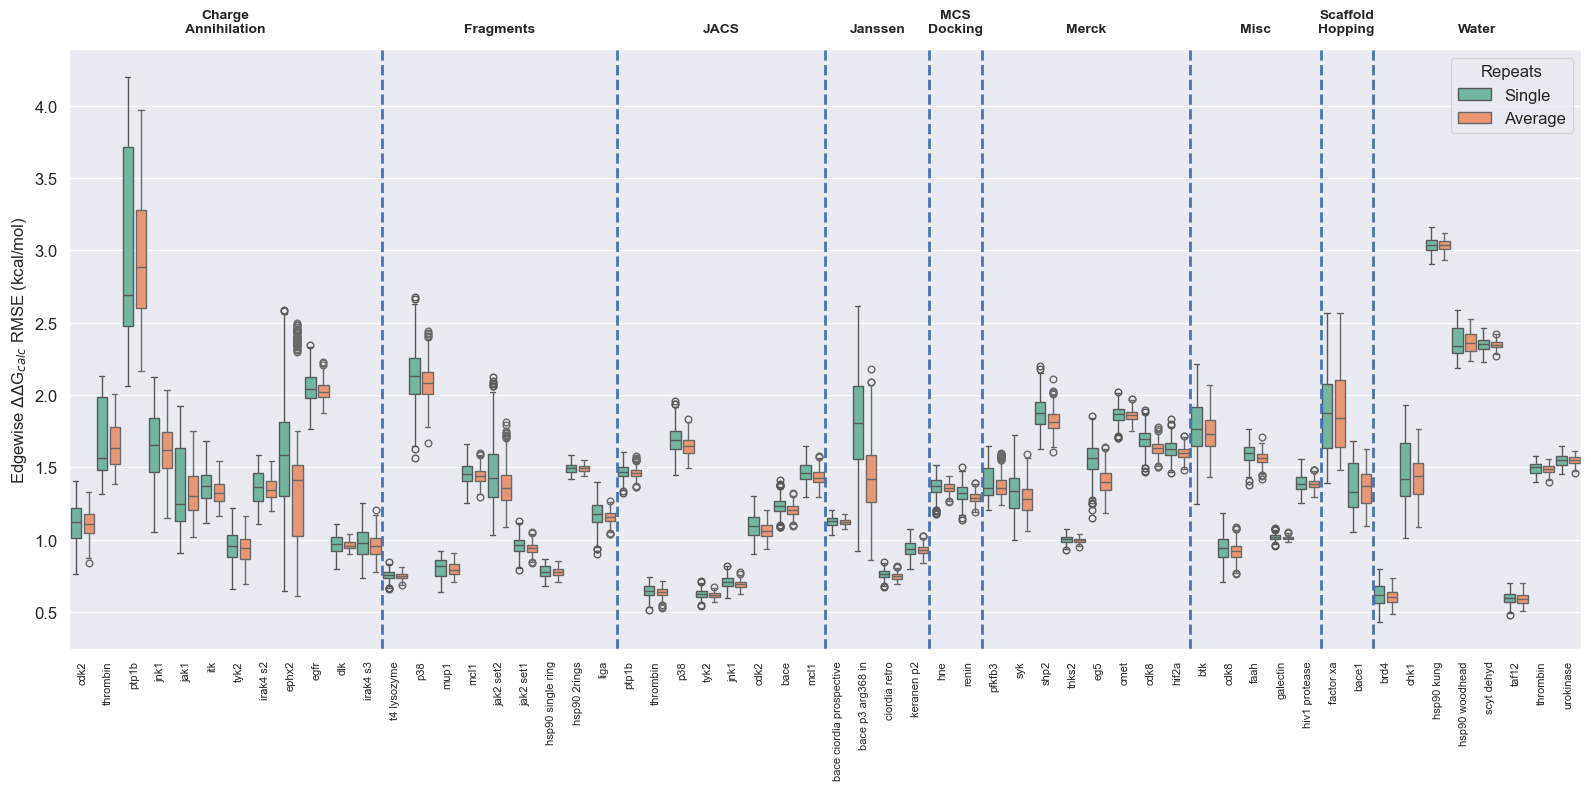

In [ ]:
# plot the per-system RMSE distributions for the public datasets using boxplots grouped by system group 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
public_rmse_data = []
for (system, target), data in public_edgewise_rmse.items():
    public_rmse_data.append({
        "system group": system,
        "system name": target,
        "RMSE (kcal/mol) single": data["single"],
        "RMSE (kcal/mol) average": data["average"],
    })

public_rmse_df = pd.DataFrame(public_rmse_data)
# sort by system group
public_rmse_df.sort_values(by=["system group"], inplace=True)
# Plot the RMSE distributions for the public datasets
x = np.arange(len(public_rmse_df))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.8
palette = sns.color_palette("Set2")
for index , row in public_rmse_df.iterrows():
    sns.boxplot(x=x[index] - (bar_width/2), y=row["RMSE (kcal/mol) single"],  ax=ax, width=bar_width, color=palette[0])
    sns.boxplot(x=x[index] + (bar_width/2), y=row["RMSE (kcal/mol) average"], ax=ax, width=bar_width, color=palette[1])
    
# Set labels and ticks
print(x)
ax.set_xticks((x*2) + 0.5)
names = public_rmse_df['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=8)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontdict={"fontsize": 12})
# add the legend once
ax.legend(["Single", "Average"], fontsize=12, title="Repeats", title_fontsize=12)

# Add colored background for classes
unique_classes = public_rmse_df['system group'].unique()
class_bounds = public_rmse_df.groupby('system group').size().cumsum().to_dict()

class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls] *2
    # add dashed lines for the span but not the fill
    if cls != "charge_annihilation_set":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
    class_start = end


# plt.legend(title="Repeats", fontsize=12, title_fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(-0.5, len(public_rmse_df) - 0.5)
plt.tight_layout()
# plt.show()
plt.savefig("per_system_edgewise_rmse_repeat_public.png", dpi=300, bbox_inches='tight')

In [69]:
# for each system test for a significant difference between the single and average RMSE distributions using a welch's t-test
from scipy.stats import mannwhitneyu

public_significant_differences = []
for (system, target), data in public_edgewise_rmse.items():
    single_rmse = data["single"]
    average_rmse = data["average"]
    # perform a welch's t-test
    t_stat, p_value = mannwhitneyu(single_rmse, average_rmse, alternative="greater")
    if p_value < 0.05:
        print(f"Significant difference between single and average RMSE for {system} - {target}: t-statistic = {t_stat:.3f}, p-value = {p_value:.3e}")
    public_significant_differences.append({
        "system group": system,
        "system name": target,
        "t-statistic": t_stat,
        "p-value": p_value
    })
public_significant_differences_df = pd.DataFrame(public_significant_differences)
public_significant_differences_df.sort_values(by=["system group", "system name"], inplace=True)
public_significant_differences_df

Significant difference between single and average RMSE for charge_annihilation_set - cdk2: t-statistic = 529668.000, p-value = 1.080e-02
Significant difference between single and average RMSE for charge_annihilation_set - dlk: t-statistic = 545065.000, p-value = 2.417e-04
Significant difference between single and average RMSE for charge_annihilation_set - egfr: t-statistic = 557055.000, p-value = 4.974e-06
Significant difference between single and average RMSE for charge_annihilation_set - ephx2: t-statistic = 693711.000, p-value = 3.616e-51
Significant difference between single and average RMSE for charge_annihilation_set - irak4_s2: t-statistic = 533208.000, p-value = 5.062e-03
Significant difference between single and average RMSE for charge_annihilation_set - irak4_s3: t-statistic = 566033.000, p-value = 1.581e-07
Significant difference between single and average RMSE for charge_annihilation_set - itk: t-statistic = 620417.000, p-value = 5.544e-21
Significant difference between sin

,system group,system name,t-statistic,p-value
0,charge_annihilation_set,cdk2,529668.0,1.079622e-02
1,charge_annihilation_set,dlk,545065.0,2.416831e-04
2,charge_annihilation_set,egfr,557055.0,4.973597e-06
3,charge_annihilation_set,ephx2,693711.0,3.615958e-51
4,charge_annihilation_set,irak4_s2,533208.0,5.061502e-03
5,charge_annihilation_set,irak4_s3,566033.0,1.580569e-07
6,charge_annihilation_set,itk,620417.0,5.544417e-21
7,charge_annihilation_set,jak1,471204.0,9.871266e-01
8,charge_annihilation_set,jnk1,540900.0,7.691237e-04
9,charge_annihilation_set,ptp1b,479163.0,9.466998e-01


In [70]:
# calculate the average difference in the median RMSE between the single and average distributions for each system
public_median_rmse_diff = []
for (system, target), data in public_edgewise_rmse.items():
    single_rmse = data["single"]
    average_rmse = data["average"]
    median_single = np.median(single_rmse)
    median_average = np.median(average_rmse)
    diff = abs(median_average - median_single)
    public_median_rmse_diff.append(diff)
np.mean(public_median_rmse_diff), np.std(public_median_rmse_diff)

(0.037388610212601404, 0.0605503285802108)

In [ ]:
# same again for the private datasets
private_edgewise_rmse = {}
for system in private_edge_data["partner_id"].unique():
    system_edges = private_edge_data[private_edge_data["partner_id"] == system].copy(deep=True).reset_index(drop=True)
    for target in system_edges["dataset_name"].unique():
        print(f"Calculating distributions for {system} - {target}")
        target_edges = system_edges[system_edges["dataset_name"] == target].copy(deep=True).reset_index(drop=True)
        target_dg = private_dg_data[(private_dg_data["partner_id"] == system) & (private_dg_data["dataset_name"] == target)].copy(deep=True).reset_index(drop=True)
        single_rmse, single_kendall = claculate_single_distribution(target_edges, target_dg)
        avg_rmse, avg_kendall = calculate_average_distribution(target_edges, target_dg)
        private_edgewise_rmse[(system, target)] = {
            "single": single_rmse,
            "average": avg_rmse
        }

Calculating distributions for ASAP - Enterovirus
Calculating distributions for ASAP - MERS
Calculating distributions for ASAP - SARS2-Mpro
Calculating distributions for AbbVie - AbbVie_private_A
Calculating distributions for AbbVie - AbbVie_private_B
Calculating distributions for BI - systemB
Calculating distributions for BI - systemC
Calculating distributions for BI - systemD
Calculating distributions for BI - systemE
Calculating distributions for BI - systemF
Calculating distributions for BI - systemG
Calculating distributions for BI - systemH
Calculating distributions for BI - systemI
Calculating distributions for BI - systemK
Calculating distributions for EliLilly - Project0
Calculating distributions for EliLilly - Project1
Calculating distributions for EliLilly - Project2
Calculating distributions for GSK - GSK_PRIVATE_1
Calculating distributions for GSK - GSK_PRIVATE_2
Calculating distributions for Genentech - GNE_Private
Calculating distributions for Janssen - systemA_set1
Calcu

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]


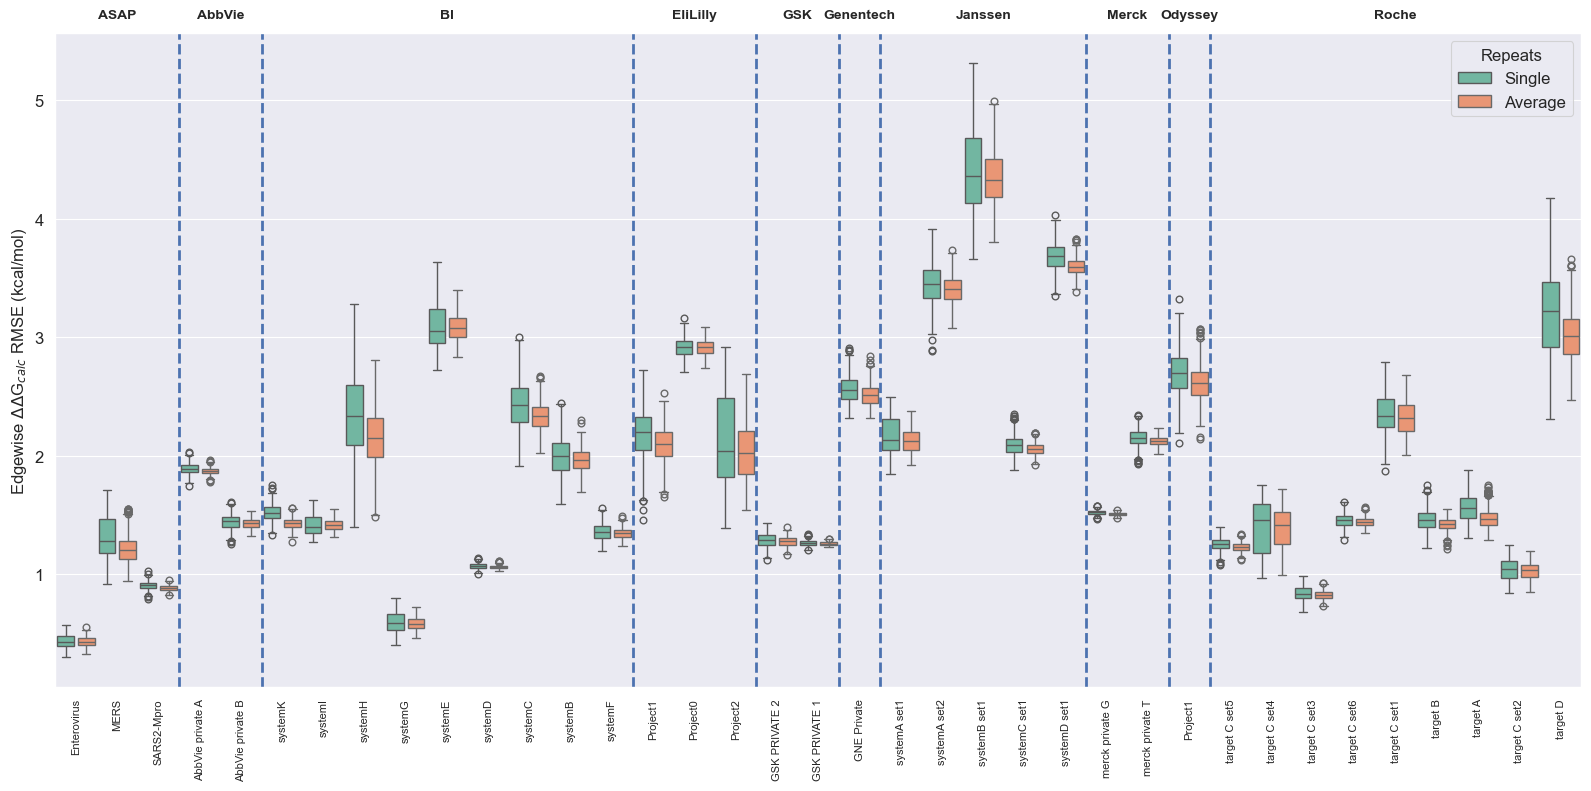

In [ ]:
private_rmse_data = []
for (system, target), data in private_edgewise_rmse.items():
    private_rmse_data.append({
        "system group": system,
        "system name": target,
        "RMSE (kcal/mol) single": data["single"],
        "RMSE (kcal/mol) average": data["average"],
    })

private_rmse_df = pd.DataFrame(private_rmse_data)
# sort by system group
private_rmse_df.sort_values(by=["system group"], inplace=True)
# Plot the RMSE distributions for the private datasets
x = np.arange(len(private_rmse_df))

# Set up the figure
fig, ax = plt.subplots(figsize=(16, 8))
bar_width = 0.8

for index , row in private_rmse_df.iterrows():
    sns.boxplot(x=x[index] - (bar_width/2), y=row["RMSE (kcal/mol) single"],  ax=ax, width=bar_width, color=palette[0])
    sns.boxplot(x=x[index] + (bar_width/2), y=row["RMSE (kcal/mol) average"], ax=ax, width=bar_width, color=palette[1])
# Set labels and ticks
print(x)
ax.set_xticks((x*2) + 0.5)
names = private_rmse_df['system name'].str.replace("_", " ")
ax.set_xticklabels(names, rotation=90, fontsize=8)
ax.set_ylabel(r"Edgewise $\Delta\Delta$G$_{calc}$ RMSE (kcal/mol)", fontdict={"fontsize": 12})
# add the legend once
ax.legend(["Single", "Average"], fontsize=12, title="Repeats", title_fontsize=12)

# Add colored background for classes
unique_classes = private_rmse_df['system group'].unique()
class_bounds = private_rmse_df.groupby('system group').size().cumsum().to_dict()

class_start = 0

colors = sns.color_palette("colorblind", len(unique_classes))
class_conversion = {"bayer_macrocycles": "Bayer\nMacrocycles", "charge_annihilation_set": "Charge\nAnnihilation", "fragments": "Fragments", "jacs_set": "JACS", "janssen_bace": "Janssen", "merck": "Merck", "miscellaneous_set": "Misc", "scaffold_hopping_set": "Scaffold\nHopping", "water_set": "Water", "mcs_docking_set": "MCS\nDocking"}
for i, cls in enumerate(unique_classes):
    cls_name = class_conversion.get(cls, cls)
    end = class_bounds[cls] *2
    # add dashed lines for the span but not the fill
    if cls != "ASAP":
        ax.axvline(class_start - 0.5, linestyle='--', linewidth=2)
#     ax.axvspan(class_start - 0.5, end - 0.5, facecolor=colors[i], alpha=0.2)
    center = (class_start + end - 1) / 2
    ax.text(center, ax.get_ylim()[1] + 0.1, cls_name, ha='center', va='bottom', fontsize=10, weight='bold')
    class_start = end


# plt.legend(title="Repeats", fontsize=12, title_fontsize=12)
plt.yticks(fontsize=12)
# plt.xlim(-0.5, len(public_rmse_df) - 0.5)
plt.tight_layout()
# plt.show()
plt.savefig("per_system_edgewise_rmse_repeat_private.png", dpi=300, bbox_inches='tight')

In [71]:
# calculate the average difference in the median RMSE between the single and average distributions for each system for the private datasets
private_median_rmse_diff = []
for (system, target), data in private_edgewise_rmse.items():
    single_rmse = data["single"]
    average_rmse = data["average"]
    median_single = np.median(single_rmse)
    median_average = np.median(average_rmse)
    diff = abs(median_average - median_single)
    private_median_rmse_diff.append(diff)
np.mean(private_median_rmse_diff), np.std(private_median_rmse_diff)

(0.043053552139346, 0.047456073209860915)